In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/eas_508_project/notebooks
Current working directory: /shared_folder/eas_508_project


In [2]:
pbp_path = 'data/interim/pbp/'

pbp_name = 'featured_11_13.csv'

df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})
shape = df.shape
columns = df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

df.head()

/tmp/ipykernel_4753/2280615120.py:5: DtypeWarning: Columns (84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbp_path + pbp_name, dtype={'personnel_num': 'string'})


✔✔✔ File Loaded

Shape: (307574, 114)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'yrdln', 'ydstogo', 'ydsnet', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'run_location', 'run_gap', 'score_differential', 'no_score_prob', 'fg_prob', 'td_prob', 'ep', 'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'penalty', 'field_goal_attempt', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 'season', 'order_sequence', 'stadium', 'weather', 'nfl_api_id', 'fixed_drive'

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense,home_team,...,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa,yard_group,previous_success,home,spread
0,2016_01_BUF_BAL,58,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,0to5,0.0,1,-3.0
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441436,0.441424,0.021170,0to5,1.0,1,-3.0
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.464400,0.462669,0.057628,0.441436,0.441424,0.021170,0to5,1.0,1,-3.0
3,2016_01_BUF_BAL,130,BAL,UNDER_CENTER,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.426230,0.426601,0.019530,0.429168,0.429205,0.010042,5to10,0.0,1,-3.0
4,2016_01_BUF_BAL,154,BAL,UNDER_CENTER,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11,BAL,...,0.420136,0.420369,0.006901,0.429168,0.429205,0.010042,0to5,1.0,1,-3.0


In [3]:
# Useable Features
features = ['down',
            'ydstogo',
            'ydstosuccess',
            'yard_group',
            'yardline_100',
            'previous_success',
            'offense_formation',
            'defenders_in_box',
            'QB',
            'RB',
            'TE',
            'WR',
            'OL',
            'O_OTHER',
            'DL',
            'LB',
            'DB',
            'D_OTHER',
            'home',
            'score_differential',
            'spread',
            'total_line',
            'qtr',
            'quarter_seconds_remaining',
            'success']
cat_features = ['yard_group',
                'offense_formation']
target = 'success'

In [4]:
model_df = df[features]

for col in cat_features:
    model_df[col] = model_df[col].astype(str)
    model_df[col] = LabelEncoder().fit_transform(model_df[col])
model_df = model_df.copy()

X = model_df.drop(columns=target)
y = model_df[target]

/tmp/ipykernel_4753/3457461786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = model_df[col].astype(str)
/tmp/ipykernel_4753/3457461786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = LabelEncoder().fit_transform(model_df[col])
/tmp/ipykernel_4753/3457461786.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)

In [6]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X_scaled)


In [13]:
model_df['cluster'] = cluster_ids

In [14]:
model_df.groupby('cluster')[features].mean()

,down,ydstogo,ydstosuccess,yard_group,yardline_100,previous_success,offense_formation,defenders_in_box,QB,RB,...,LB,DB,D_OTHER,home,score_differential,spread,total_line,qtr,quarter_seconds_remaining,success
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.681631,6.640761,3.174454,0.320929,43.553351,0.480205,1.833775,7.814026,1.008503,1.241200,...,3.296608,3.851239,0.009875,0.516778,1.794642,-1.897824,45.173356,2.625857,437.598885,0.420133
1,1.463149,8.142544,3.728295,0.349552,51.702035,0.469061,1.657269,7.123996,1.004763,1.308722,...,3.231467,4.192971,0.001747,0.507928,1.070171,-1.881520,45.277155,2.422104,487.053897,0.435064
2,2.466227,11.046243,8.376649,3.297105,53.668444,0.080286,1.045187,5.701898,1.003326,1.017100,...,2.763308,5.276103,0.001933,0.492705,-2.218596,-1.828446,45.237226,2.598040,417.144121,0.375062
3,1.600294,7.332152,3.442138,0.000462,49.604640,0.528018,1.176319,6.086946,1.003860,1.016442,...,2.752113,5.090937,0.001179,0.503656,-3.176643,-1.865794,45.560885,2.610295,407.136332,0.478716


In [15]:
import numpy as np
print(np.bincount(cluster_ids))

[ 10937  83567  83277 129793]


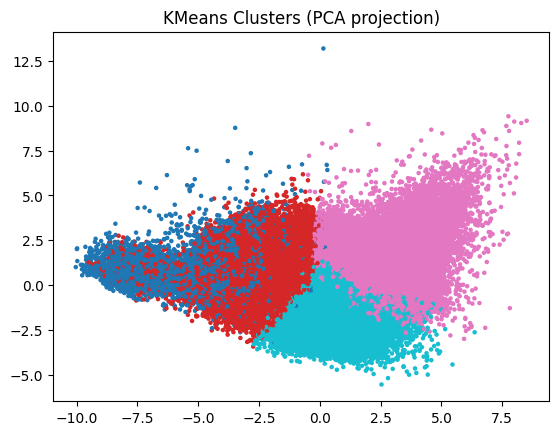

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.scatter(coords[:,0], coords[:,1], c=cluster_ids, cmap='tab10', s=5)
plt.title("KMeans Clusters (PCA projection)")
plt.show()

/opt/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


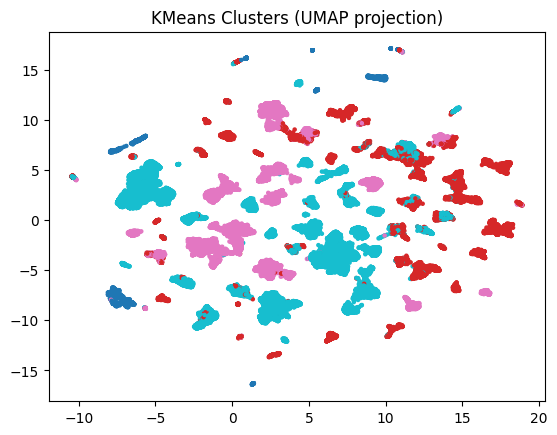

In [17]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb2d = reducer.fit_transform(X_scaled)

plt.scatter(emb2d[:,0], emb2d[:,1], c=cluster_ids, cmap='tab10', s=5)
plt.title("KMeans Clusters (UMAP projection)")
plt.show()